In [1]:
import numpy as np
np.random.seed(1001)

import pickle
import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.cross_validation import StratifiedKFold
import sklearn
from sklearn.model_selection import train_test_split
import dask.dataframe as dd
from dask import array

import librosa
import IPython.display as ipd  # To play sound in the notebook
import librosa.display

import keras
from keras.layers import Conv1D, Dropout, Dense, MaxPooling1D, Flatten
from keras import Sequential

%matplotlib inline
matplotlib.style.use('ggplot')

import dask
from dask.distributed import Client, wait, progress

C:\Users\chris\Anaconda3\envs\audio\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
client = Client()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
metadata = pd.read_csv("file_metadata.csv", index_col=0)

# Features

In [5]:
client.restart()

Client Scheduler: tcp://127.0.0.1:62930 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.46 GB


In [6]:
y, sr = librosa.load(metadata["filepath"].iloc[0])

In [7]:
len(librosa.feature.spectral_flatness(y))

1

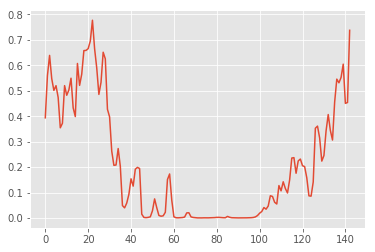

In [8]:
# Spectral flatness
plt.plot(librosa.feature.spectral_flatness(y)[0])

# Spectral contrast

In [9]:
# each row of spectral contrast values corresponds to a given octave-based frequency

n = 2
len(librosa.feature.spectral_contrast(y, sr, n_bands=n))

3

In [10]:
def get_spec_contrast_features(y, sr):
    n_bands = 3
    vals = librosa.feature.spectral_contrast(y,n_bands=n_bands)
    means = [np.mean(x) for x in vals]
    stds = [np.std(x) for x in vals]

    for i in range(n_bands+1):
        plt.plot(vals[i])
    return means, stds

([20.4819336937591, 11.763805230162642, 15.675733982039421, 30.6657186784521],
 [9.93648825074117, 4.362921028288391, 4.953411190605515, 6.3135557571715895])

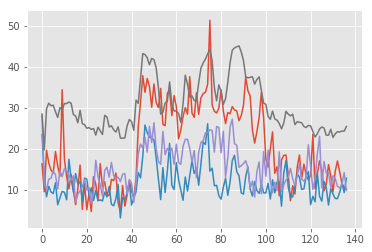

In [11]:

y, sr = librosa.load(metadata["filepath"].iloc[3])
get_spec_contrast_features(y, sr)

# Spectral flatness - WILL ONLY WORK IF WE REMOVE NOISE FIRST
Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to being tone-like [1]. A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. It is often converted to decibel.

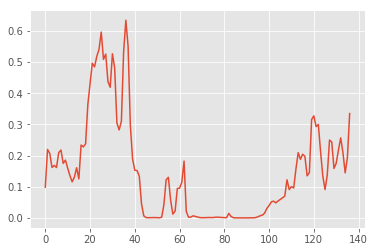

In [12]:
n = 2
plt.plot(librosa.feature.spectral_flatness(y)[0])

In [13]:
def get_spec_flatness_features(y):
    vals = librosa.feature.spectral_flatness(y)
    mean = [np.mean(x) for x in vals]
    std = [np.std(x) for x in vals]
    plt.plot(librosa.feature.spectral_flatness(y)[0])
    return mean, std

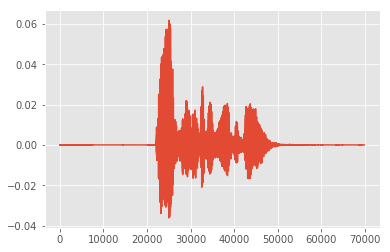

In [14]:
plt.plot(y)

([0.15351795], [0.18956923])

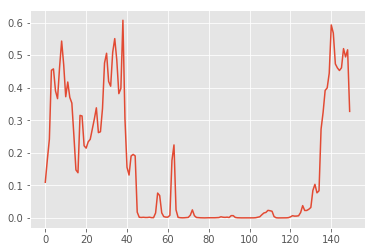

In [15]:
y, sr = librosa.load(metadata["filepath"].iloc[5])
get_spec_flatness_features(y)

# Spectral Rolloff

1


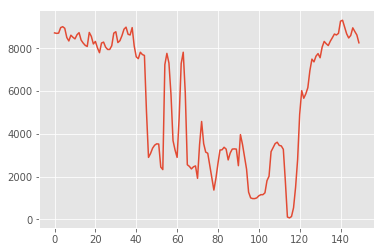

In [16]:
print(len(librosa.feature.spectral_rolloff(y,sr)))
plt.plot(librosa.feature.spectral_rolloff(y,sr)[0])

In [17]:
def get_ts_features(y,sr, hop_length=32):
    n_cont_bands = 2
    res = pd.DataFrame(columns=[f"contrast_band_{x}" for x in range(n_cont_bands+1)].extend(["sroll", "sflat"]))
    
    scont = librosa.feature.spectral_contrast(y,n_bands=n_cont_bands, hop_length=hop_length)
    
    for i in range(n_cont_bands + 1):
        res[f"contrast_band_{i}"] = scont[i]
        
    sroll = librosa.feature.spectral_rolloff(y,sr, hop_length=hop_length)[0].T
    res["sroll"] = sroll
    
    sflat = librosa.feature.spectral_flatness(y, hop_length=hop_length)[0].T
    res["sflat"] = sflat
    
    y_df = pd.DataFrame(y)
    res["downsampled"] = y_df.groupby(y_df.index//hop_length).mean().rolling(2).mean()
    res["downsampled_smooth_abs"] = y_df.abs().groupby(y_df.index//hop_length).mean().rolling(6).mean()

    return res.fillna(method="backfill").fillna(method="ffill")

y, sr = librosa.load(metadata["filepath"].iloc[0])
res = get_ts_features(y, sr)

In [18]:
def get_length_in_seconds(y,sr):
    return len(y)/sr

def create_samples_from_fn(idx, fn, return_data=False, save_data=True):
    """
    Also trims silence from a file
    """
    desired_sr = 22050
    try:
        # Load, resample if needed
        y, sr = librosa.load(fn)
    except:
        return None
    if sr != desired_sr:
        y = librosa.core.resample(y, sr, desired_sr)
        sr = desired_sr

    # Standard scaling
    standardScaler = StandardScaler()    
    y = standardScaler.fit_transform(y.reshape(-1, 1)).reshape(1, -1)[0]

    length = get_length_in_seconds(y, sr)

    #ax.plot(y, alpha=0.3)
    #print(f"{np.round(length, 4)}")
    # Trim silence
    y_trimmed = librosa.effects.trim(y, top_db=12.5)[0]
    length_trimmed = get_length_in_seconds(y_trimmed, sr)
    #print(f"{np.round(length_trimmed, 4)}")
    #plt.plot(y_trimmed, alpha=0.5)

    # Split into chunks
    chunk_len = int(sr / 2) # .5 seconds
    end = len(y_trimmed) - (len(y_trimmed) % chunk_len)
    n_chunks = int(end / chunk_len)
    if n_chunks == 0:
        return None
    y_trimmed_chunks = np.split(y_trimmed[:end], n_chunks)
    
    #print([x.shape for x in y_trimmed_chunks])

    # TODO: Engineer some damn features!
    
    y_trimmed_chunks = [x for x in y_trimmed_chunks]
    y_feature_chunks = [get_ts_features(ch, desired_sr).values for ch in y_trimmed_chunks]

    
    for i in range(len(y_feature_chunks)):
        res = pd.DataFrame(y_feature_chunks[i])
        res.columns = res.columns.astype(str)
        res["sample"]=f"{idx}-{i}" # Store the
        if save_data:
            res.to_parquet(f"../data/listenr-ml/preprocessed_2/{idx}-{i}.parquet")
    if return_data:
        return res

In [19]:
def establish_data(metadata):
    """
    Save all preprocessed (and eventually feature engineered samples)
    """
    n = len(metadata)
    
    futures = []

    for idx, data in metadata.iterrows():
        futures.append(client.submit(create_samples_from_fn, idx, data["filepath"], return_data=False, save_data=True,
                                    key=idx))
    return futures
    

In [20]:
client

Client Scheduler: tcp://127.0.0.1:62930 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.46 GB


In [47]:
#futures = establish_data(metadata)

In [26]:
def load_one(fn):
    res = pd.read_parquet(f"../data/listenr-ml/preprocessed_2/{fn}")
    return res
res = load_one("0-0.parquet")

In [120]:
def load_data_and_scale(client, metadata):
    """
    Load all samples into keras-digestible format
    """
    fns = os.listdir("../data/listenr-ml/preprocessed_2/")
    # Get the original sample's metada for each of these chunks
    indices = [int(x.split("-")[0]) for x in fns]
    these_samples_metadata = metadata.loc[indices]
    
    y = pd.get_dummies(these_samples_metadata["emo"].values)
    sample_weight = these_samples_metadata["emo_intensity"] + 1
    
    # First, train a standard scaler on all elements
    df = dd.read_parquet("../data/listenr-ml/preprocessed_2/*.parquet").compute()
    cols = df.columns
    sScaler = StandardScaler()

    # Transform to standard scale, then ignore the sample name column
    df[df.columns[:7]] = sScaler.fit_transform(df[df.columns[:7]])

    # Do we need a sort on each of these? 
    # Groupby sample (which removes sample column), then get the df values, group these all together into an np object
    groups = df.groupby("sample")
    X = np.array([x[1].drop("sample", axis=1).values for x in groups])
    labels = [x[0] for x in groups]
    
    return X, y, sample_weight, labels

In [121]:
X, y, sw, lbl =load_data_and_scale(client, metadata)

In [122]:
X.shape

(4686, 345, 7)

In [123]:
y.shape

(4686, 6)

In [133]:
def build_1D_model(sample_len, n_classes, filter_size, pool_size=3, dropout=0.2, base_dense=32):
    model = Sequential()
    model.add(Conv1D(128, filter_size,
                            padding='valid',
                            input_shape=(sample_len, 7),
                            activation="relu"))
    model.add(MaxPooling1D(padding="same", pool_size=(pool_size)))
    model.add(Dropout(dropout))
    
    model.add(Conv1D(128, filter_size,
                            padding="same",
                            activation="relu"))
    model.add(MaxPooling1D(padding="same", pool_size=(pool_size)))
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(base_dense, activation="relu"))
    model.add(Dropout(dropout))    
    model.add(Dense(int(base_dense / 2), activation="relu"))
    model.add(Dense(n_classes, activation="softmax"))
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])
    return model

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [128]:
X_test[0]

array([[ 0.47600977, -0.09775851, -0.67623998, ..., -0.30317684,
        -0.05593598, -0.79774719],
       [ 0.418683  , -0.24491976, -0.71976461, ..., -0.29218705,
        -0.05593598, -0.79774719],
       [ 0.61612824, -0.49095051, -0.72307823, ..., -0.28292638,
         0.2183546 , -0.79774719],
       ...,
       [-1.2721302 ,  1.43725402, -1.29848322, ..., -0.00809364,
         2.76532276,  0.22500186],
       [-1.2752363 ,  1.76870623, -1.23500534, ..., -0.0426704 ,
        -0.60305696,  0.21137478],
       [-1.27689854,  2.43142913, -1.1217806 , ..., -0.07418492,
        -1.56741417,  0.19170544]])

In [130]:
filter_size_df = pd.DataFrame(columns=["loss", "acc"])

for fs in [3,6,12,28]:
    print(fs)
    md = build_1D_model(345, len(y.columns), filter_size=(fs))
    md.fit(X_train, y_train, epochs=20, validation_split = 0.1, verbose=1, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')])
    res = md.evaluate(X_test, y_test)
    filter_size_df.loc[fs] = res
    print(fs)
    print(res)
    
filter_size_df.to_parquet("filter_size_df.parquet")    

3
Train on 3584 samples, validate on 399 samples
Epoch 1/20
3584/3584 [==============================] - ETA: 3:47 - loss: 1.9655 - acc: 0.187 - ETA: 1:17 - loss: 1.8868 - acc: 0.239 - ETA: 47s - loss: 1.8708 - acc: 0.218 - ETA: 40s - loss: 1.8805 - acc: 0.20 - ETA: 35s - loss: 1.8566 - acc: 0.21 - ETA: 27s - loss: 1.8580 - acc: 0.21 - ETA: 22s - loss: 1.8536 - acc: 0.20 - ETA: 19s - loss: 1.8444 - acc: 0.20 - ETA: 17s - loss: 1.8315 - acc: 0.21 - ETA: 15s - loss: 1.8207 - acc: 0.21 - ETA: 14s - loss: 1.8159 - acc: 0.21 - ETA: 13s - loss: 1.8119 - acc: 0.21 - ETA: 12s - loss: 1.8083 - acc: 0.21 - ETA: 11s - loss: 1.8006 - acc: 0.22 - ETA: 10s - loss: 1.8014 - acc: 0.21 - ETA: 9s - loss: 1.8006 - acc: 0.2132 - ETA: 9s - loss: 1.7960 - acc: 0.217 - ETA: 8s - loss: 1.7948 - acc: 0.218 - ETA: 8s - loss: 1.7921 - acc: 0.216 - ETA: 7s - loss: 1.7937 - acc: 0.214 - ETA: 7s - loss: 1.7919 - acc: 0.214 - ETA: 7s - loss: 1.7928 - acc: 0.212 - ETA: 6s - loss: 1.7914 - acc: 0.213 - ETA: 6s - loss:

3584/3584 [==============================] - ETA: 5s - loss: 1.5121 - acc: 0.375 - ETA: 4s - loss: 1.6179 - acc: 0.333 - ETA: 5s - loss: 1.6265 - acc: 0.328 - ETA: 5s - loss: 1.6617 - acc: 0.300 - ETA: 5s - loss: 1.6589 - acc: 0.290 - ETA: 5s - loss: 1.6739 - acc: 0.284 - ETA: 5s - loss: 1.6586 - acc: 0.293 - ETA: 4s - loss: 1.6531 - acc: 0.276 - ETA: 4s - loss: 1.6566 - acc: 0.279 - ETA: 4s - loss: 1.6514 - acc: 0.287 - ETA: 4s - loss: 1.6511 - acc: 0.291 - ETA: 4s - loss: 1.6511 - acc: 0.292 - ETA: 4s - loss: 1.6515 - acc: 0.284 - ETA: 4s - loss: 1.6476 - acc: 0.287 - ETA: 4s - loss: 1.6469 - acc: 0.288 - ETA: 4s - loss: 1.6473 - acc: 0.290 - ETA: 4s - loss: 1.6572 - acc: 0.284 - ETA: 3s - loss: 1.6512 - acc: 0.285 - ETA: 3s - loss: 1.6488 - acc: 0.291 - ETA: 3s - loss: 1.6454 - acc: 0.294 - ETA: 3s - loss: 1.6398 - acc: 0.292 - ETA: 3s - loss: 1.6387 - acc: 0.292 - ETA: 3s - loss: 1.6335 - acc: 0.297 - ETA: 3s - loss: 1.6390 - acc: 0.296 - ETA: 3s - loss: 1.6410 - acc: 0.295 - ETA: 

3584/3584 [==============================] - ETA: 5s - loss: 1.5696 - acc: 0.281 - ETA: 3s - loss: 1.6082 - acc: 0.239 - ETA: 4s - loss: 1.6120 - acc: 0.287 - ETA: 3s - loss: 1.6022 - acc: 0.312 - ETA: 4s - loss: 1.5933 - acc: 0.308 - ETA: 4s - loss: 1.5747 - acc: 0.315 - ETA: 4s - loss: 1.5790 - acc: 0.320 - ETA: 3s - loss: 1.5823 - acc: 0.323 - ETA: 3s - loss: 1.5710 - acc: 0.326 - ETA: 3s - loss: 1.5693 - acc: 0.322 - ETA: 3s - loss: 1.5593 - acc: 0.328 - ETA: 3s - loss: 1.5573 - acc: 0.330 - ETA: 3s - loss: 1.5604 - acc: 0.326 - ETA: 3s - loss: 1.5707 - acc: 0.324 - ETA: 3s - loss: 1.5789 - acc: 0.323 - ETA: 3s - loss: 1.5677 - acc: 0.324 - ETA: 3s - loss: 1.5699 - acc: 0.324 - ETA: 3s - loss: 1.5668 - acc: 0.322 - ETA: 3s - loss: 1.5662 - acc: 0.327 - ETA: 3s - loss: 1.5677 - acc: 0.329 - ETA: 3s - loss: 1.5660 - acc: 0.331 - ETA: 3s - loss: 1.5687 - acc: 0.329 - ETA: 3s - loss: 1.5691 - acc: 0.328 - ETA: 3s - loss: 1.5681 - acc: 0.330 - ETA: 3s - loss: 1.5717 - acc: 0.332 - ETA: 

KeyboardInterrupt: 

# Verdict: Filter size = 6

# Max pooling pool size grid

In [30]:
pool_size_df = pd.DataFrame(columns=["loss", "acc"])

for ps in [2,3,4,5]:
    print(ps)
    md = build_1D_model(11025, len(y.columns), filter_size=6, pool_size=ps)
    md.fit(X_train, y_train, epochs=20, validation_split = 0.1, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')])
    res = md.evaluate(X_test, y_test)
    filter_size_df.loc[fs] = res
    print(ps)
    print(res)
    
pool_size_df.to_parquet("pool_size_df.parquet")    

2
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s 9ms/step
2
[1.6439043208850737, 0.3257467991766516]
3
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 7ms/step
3
[1.6668227437888914, 0.3186344235584373]
4
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 6ms/step
4
[1.635248692920842, 0.31578947342985214]
5
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  -

In [32]:
base_dense_df = pd.DataFrame(columns=["loss", "acc"])

for bd in [16,32,64,128,256,512]:
    print(bd)
    md = build_1D_model(11025, len(y.columns), filter_size=6, pool_size=5, base_dense=bd)
    md.fit(X_train, y_train, epochs=20, validation_split = 0.1, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')])
    res = md.evaluate(X_test, y_test)
    filter_size_df.loc[fs] = res
    print(bd)
    print(res)
    
base_dense_df.to_parquet("base_dense_df.parquet")

16
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 7ms/step
16
[1.6258877446268225, 0.3200568988346952]
32
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 5ms/step
32
[1.6230627406881342, 0.3257467991766516]
64
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 6ms/step
64
[1.6736383407587347, 0.3086770977692448]
128
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  -

# Dropout grid

In [134]:
dropout_df = pd.DataFrame(columns=["loss", "acc"])

for do in [0.1, 0.2, 0.4]:
    print(do)
    md = build_1D_model(345, len(y.columns), filter_size=6, pool_size=5, base_dense=256, dropout=do)
    md.fit(X_train, y_train, epochs=20, validation_split = 0.1, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')])
    res = md.evaluate(X_test, y_test)
    filter_size_df.loc[fs] = res
    print(do)
    print(res)
    
dropout_df.to_parquet("dropout_df.parquet")

0.1
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step
0.1
[1.5531344937735567, 0.36842105208046916]
0.2
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step
0.2
[1.5649612431505835, 0.37837837770008936]
0.4
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step
0.4
[1.5699099889011845, 0.3428165001177347]


In [235]:
res

,contrast_band_0,contrast_band_1,contrast_band_2,contrast_band_3,sroll,sflat
0,15.005856,15.803830,14.688196,24.244166,1991.821289,0.001007
1,11.538092,17.175822,11.606954,15.240302,2519.384766,0.001404
2,10.788908,21.705265,13.804521,64.722306,2842.382812,0.000076
3,9.010519,26.769925,13.071949,64.811951,2702.416992,0.000063
4,9.092612,18.925542,14.976012,64.915765,2853.149414,0.000111
5,13.974140,19.454784,17.655904,64.387228,2896.215820,0.000134
6,5.434500,15.573780,13.425573,64.634906,3445.312500,0.000189
7,9.728713,17.847287,13.085870,71.397055,2960.815430,0.000205
8,10.586659,13.704537,9.909048,78.922899,3208.447266,0.000209
9,13.767206,16.530590,15.756991,80.626487,3197.680664,0.000118


In [ ]:
def build_2D_model(n_rows, n_cols, n_classes):
    model = Sequential()
    model.add(Convolution2D(128, (3, 3),
                            padding='same',
                            input_shape=(n_rows, n_cols, 1),
                            activation="relu"))
    model.add(MaxPooling2D(padding="same", pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Convolution2D(32, (3, 3),
                            padding="same",
                            activation="relu"))
    model.add(MaxPooling2D(padding="same"))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.1))    
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(n_classes, activation="softmax"))
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])
    return model

In [210]:
df = pd.DataFrame()

In [212]:
df.columns = ["a"]

ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

In [191]:
n_cont_bands=4


['contrast_band_0', 'contrast_band_1', 'contrast_band_2', 'contrast_band_3']

# MFCC

In [69]:
len(librosa.feature.mfcc(y, sr))

20

In [154]:
librosa.feature.mfcc(y, sr, n_mfcc=2)

array([[-786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -784.68735312, -772.52395727, -469.2811249 , -337.20794353,
        -308.07972227, -331.69814203, -338.89687997, -346.29402857,
        -335.48737472, -316.96268137, -296.43265057, -308.98232219,
        -360.85500401, -433.57715223, -428.56397162, -387.38936253,
        -388.19376744, -361.92137722, -337.51273

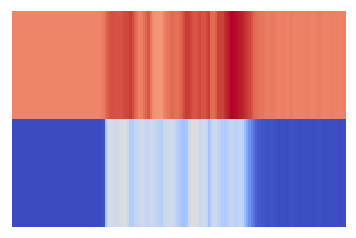

In [155]:
librosa.display.specshow(librosa.feature.mfcc(y, sr, n_mfcc=2))

ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
1000
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
FILE ARGH - 1009_TAI_ANG_XX.wav
ARGH
ARGH
ARGH
ARGH
Wall time: 7min 21s


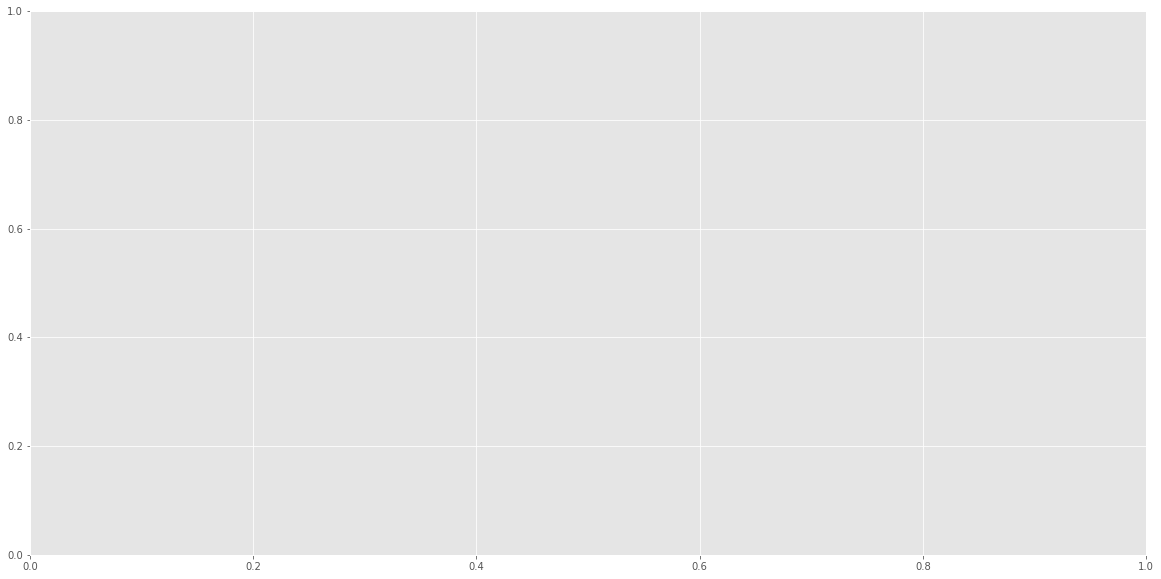

In [213]:
%%time
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

lo_cut = 0.05
window_size = 10000
mfccs = []
ys = []
bad_filepaths = []

iterator = 0
for path in filenames:
    iterator += 1
    if iterator % 1000 == 0:
        print(iterator)
    
    fn = os.path.basename(path)
    try:
        y, sr = librosa.load(path)
    except:
        bad_filepaths.append(path)
        print("FILE ARGH - {}".format(fn))
        continue
    #print(sr)
    
    # Scale between -1 and 1
    yAbs = np.abs(y)
    
    yAbs = pd.Series(yAbs)
    # WE CHOP OFF THE SILENCE AT THE END AND THE START
    # This is achieved by establishing a baseline level for "silence" which is a actually relative
    
    yRoll = yAbs.rolling(window_size).mean().values[window_size:-window_size]
    yBaseline = yRoll[0]
    
    # Finds the first yRoll index that goes above the baseline
    try:
        sound_barrier_breaks = list(yRoll > yBaseline + 0.002)
        first_baseline_break = sound_barrier_breaks.index(True)
        sound_barrier_breaks.reverse()
        last_baseline_break = -sound_barrier_breaks.index(True)        
    except:
        bad_filepaths.append(path)
        print("ARGH")
        continue
        
    # The indices are offset because of the rolling window, this corrects for them
    true_first_index = first_baseline_break + int(window_size * 0.5) # We don't know where within the window the sound started
    true_final_index = last_baseline_break - int(window_size * 0.5) # We don't know where within the window the sound started

    
    #yRoll = yRoll[first_baseline_break:last_baseline_break]
    y = y[true_first_index:true_final_index]
    
    # Scale to -1, 1 min and max
    y_scale_factor = np.max(np.abs(y))
    y = y * (1/y_scale_factor)
    
    mfcc = librosa.feature.mfcc(y, sr=sr)
    mfccs.append(mfcc)
    ys.append(y)
    #ax.plot(y, alpha=0.2)


In [216]:
bad_filenames = [os.path.basename(x) for x in bad_filepaths]

In [220]:
pd.DataFrame([bad_filenames, bad_filepaths]).to_csv("bad_files.csv")

In [228]:
with open("mfccs.p", "wb") as fp:
    pickle.dump(mfccs, fp)

In [231]:
with open("ys.p", "wb") as fp:
    pickle.dump(ys, fp)

In [214]:
len(mfccs)

1729

### Reading Audio Files

The audios are [Pulse-code modulated](https://en.wikipedia.org/wiki/Audio_bit_depth) with a [bit depth](https://en.wikipedia.org/wiki/Audio_bit_depth) of 16 and a [sampling rate](https://en.wikipedia.org/wiki/Sampling_%28signal_processing%29) of 44.1 kHz

![16-bit PCM](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Pcm.svg/500px-Pcm.svg.png)

* **Bit-depth = 16**: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values. 
* **Samplig rate = 44.1 kHz**: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100\*3.2 = 141120 values.

Let's listen to an audio file in our dataset and load it to a numpy array

## MFCC Transformations

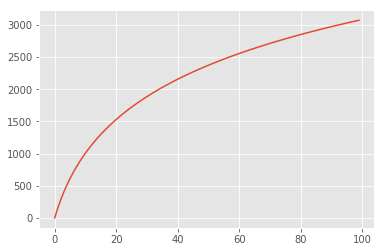

In [71]:
def mel(x):
    return 1127 * (np.log(1+(x/700)))

def melInverse(x):
    return 700 * ((np.e ** (x/1127)) - 1)

x = np.linspace(start=0,stop=10000, num=100)
y = [mel(a) for a in x]
plt.plot(y)

# Librosa bizz

In [6]:
# SR = sampling rate
#frame = short audio cliep == spectrogram column
# n_fft = samples per frame
# hop_length = num samples between frames

22050


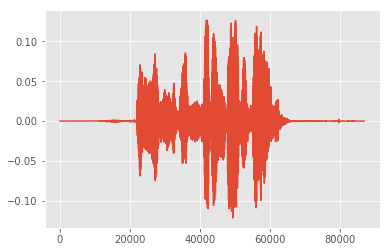

In [9]:
# Numpy array, sampling rate
y, sr = librosa.load(filenames[10])
print(sr)
plt.plot(y)

In [10]:
shortTimeFourierTransform = librosa.stft(y[200:300])
mfcc = librosa.feature.mfcc(y, sr=sr)

https://musicinformationretrieval.com/mfcc.html

In [11]:
shape = mfcc.shape

print("{} features over {} 'frames' (where a frame is an overlapping chunk of time)".format(shape[0], shape[1]))

20 features over 170 'frames' (where a frame is an overlapping chunk of time)


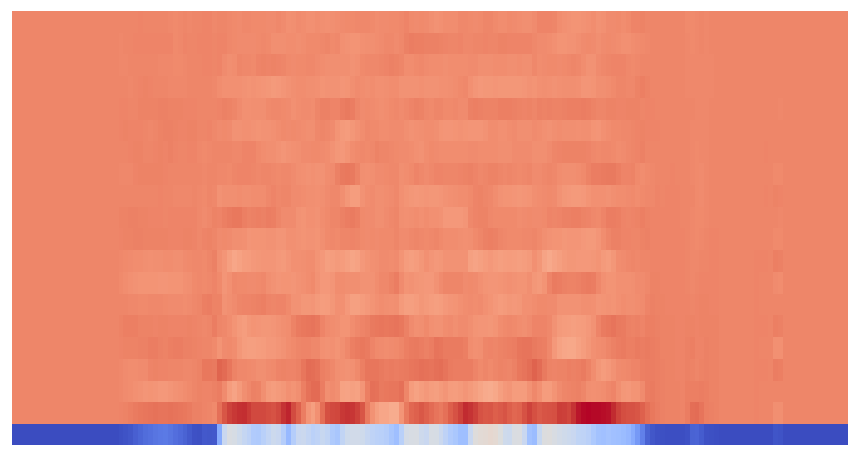

In [12]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(8)
librosa.display.specshow(mfcc)
librosa.display.specshow(mfcc)

In [13]:
# Scale the MFCCs ot unit mean and variance
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

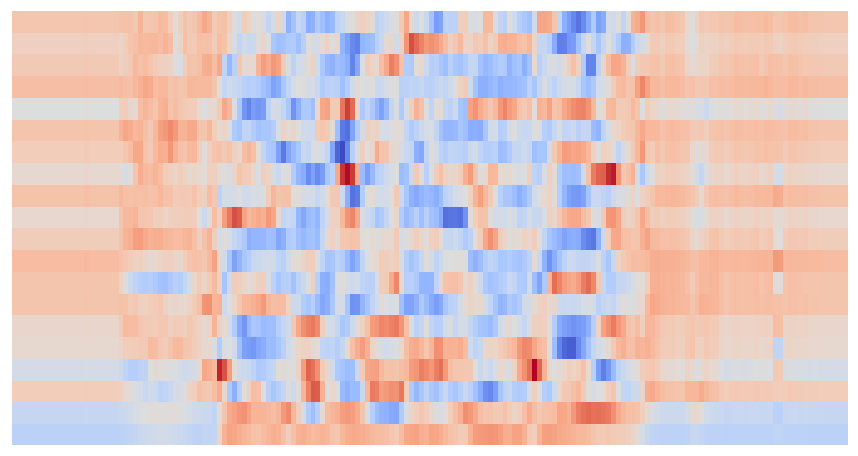

In [14]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(8)
librosa.display.specshow(mfcc)


C:\Users\chris\Anaconda3\envs\audio\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


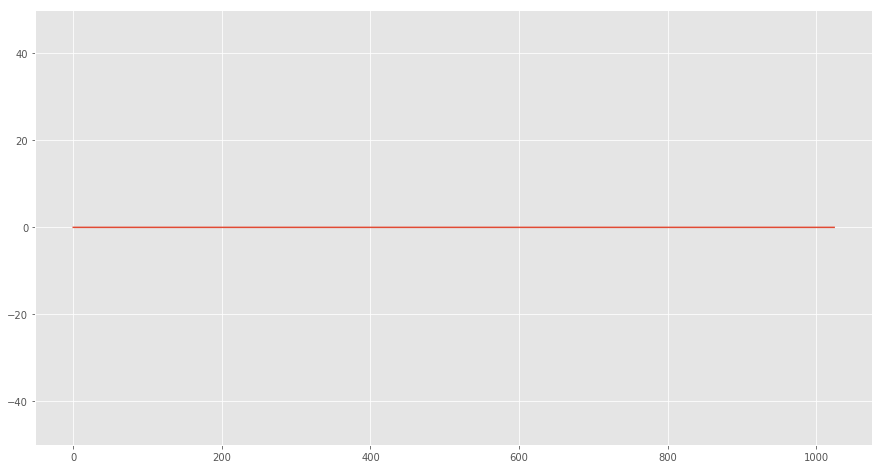

In [85]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(8)
ax.set_ylim([-50, 50])
ax.plot(shortTimeFourierTransform)

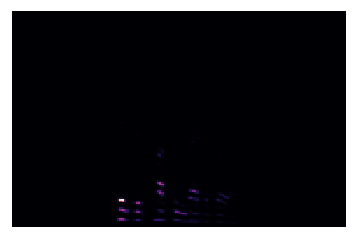

In [86]:
melspectrogram = librosa.feature.melspectrogram(y)
librosa.display.specshow(melspectrogram)

In [99]:
y, sr = librosa.load(sampleAudioFiles[50])

In [100]:
mfccass = librosa.feature.mfcc(y)

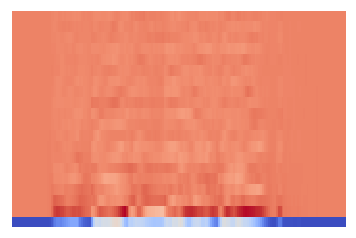

In [101]:
librosa.display.specshow(mfccass)

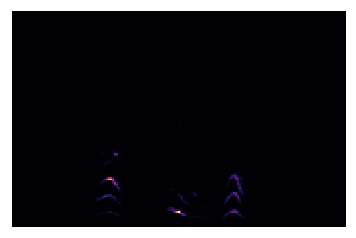

In [102]:
melspectrogram = librosa.feature.melspectrogram(y)
librosa.display.specshow(melspectrogram)

In [111]:
librosa.feature.melspectrogram(y)

array([[1.02978216e+02, 1.14474680e+02, 7.26462365e+01, ...,
        1.03840651e+02, 3.53573414e+02, 1.03370101e+03],
       [1.78534317e+02, 3.77467461e+02, 3.08798511e+02, ...,
        4.64592409e+02, 3.25459583e+02, 2.37369859e+02],
       [1.16672408e+02, 1.55782814e+02, 9.97496182e+02, ...,
        7.40739541e+02, 7.46794523e+02, 1.69696206e+02],
       ...,
       [5.98703173e-03, 1.49675297e-03, 5.40594840e-12, ...,
        4.14494436e-12, 1.55190317e-03, 6.16968651e-03],
       [5.86097716e-03, 1.46523979e-03, 4.05582458e-12, ...,
        6.48429364e-12, 1.52222115e-03, 6.05168417e-03],
       [5.78130367e-03, 1.44532145e-03, 1.05538923e-11, ...,
        1.22945254e-11, 1.50331810e-03, 5.97653651e-03]])

<a id="1d_model_building"></a>
## <center>2. Building a Model using Raw Wave</center>
We will build two models:
1. The first model will take the raw audio (1D array) as input and the primary operation will be Conv1D
2. The second model will take the MFCCs as input. (We will explain MFCC later)

<a id="1d_discription"></a>
### Keras Model using raw wave

Our model has the architecture as follows:
![raw](https://raw.githubusercontent.com/zaffnet/images/master/images/raw_model.jpg)

**Important:**
Due to the time limit on Kaggle Kernels, it is not possible to perform 10-fold training of a large model. I have trained the model locally and uploaded its output files as a dataset. If you wish to train the bigger model, change `COMPLETE_RUN = True` at the beginning of the kernel.

#### Some sssential imports

In [ ]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

<a id="configuration"></a>
#### Configuration

The Configuration object stores those learning parameters that are shared between data generators, models, and training functions. Anything that is `global` as far as the training is concerned can become the part of Configuration object.

In [ ]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

<a id="data_generator"></a>
#### DataGenerator Class

The DataGenerator class inherits from **`keras.utils.Sequence`** . It is useful for preprocessing and feeding the data to a Keras model. 
* Once initialized with a batch_size, it computes the number of batches in an epoch. The **`__len__`** method tells Keras how many batches to draw in each epoch. 
* The **`__getitem__`** method takes an index (which is the batch number) and returns a batch of the data (both X and y) after calculating the offset. During test time, only `X` is returned.
* If we want to perform some action after each epoch (like shuffle the data, or increase the proportion of augmented data), we can use the **`on_epoch_end`** method.

Note:
**`Sequence`** are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

<a id="1d_normalization"></a>
#### Normalization

Normalization is a crucial preprocessing step. The simplest method is rescaling the range of features to scale the range in [0, 1]. 

In [ ]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

* The dummy model is just for debugging purpose.
* Our 1D Conv model is fairly deep and is trained using Adam Optimizer with a learning rate of 0.0001

In [ ]:
def get_1d_dummy_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_1d_conv_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(1028, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="1d_training"></a>
#### Training 1D Conv

It is important to convert raw labels to integer indices

In [ ]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])
if not COMPLETE_RUN:
    train = train[:2000]
    test = test[:2000]

In [ ]:
config = Config(sampling_rate=16000, audio_duration=2, n_folds=10, learning_rate=0.001)
if not COMPLETE_RUN:
    config = Config(sampling_rate=100, audio_duration=1, n_folds=2, max_epochs=1)

Here is the code for 10-fold training:
* We use **`from sklearn.cross_validation.StratifiedKFold`** for splitting the trainig data into 10 folds.
* We use some Keras callbacks to monitor the training.
    * **`ModelCheckpoint`** saves the best weight of our model (using validation data). We use this weight to make test predictions.
    * **`EarlyStopping`** stops the training once validation loss ceases to decrease
    * **`TensorBoard`** helps us visualize training and validation loss and accuracy.
* We fit the model using **`DataGenerator`** for training and validation splits. 
* We get both training and test predictions and save them as .npy format. We also generate a submission file. For 10-fold CV, the number of prediction files should be 10. We will ensemble these predictions later.

```python
PREDICTION_FOLDER = "predictions_1d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)

for i, (train_split, val_split) in enumerate(skf):
    train_set = train.iloc[train_split]
    val_set = train.iloc[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

    callbacks_list = [checkpoint, early, tb]
    print("Fold: ", i)
    print("#"*50)
    if COMPLETE_RUN:
        model = get_1d_conv_model(config)
    else:
        model = get_1d_dummy_model(config)

    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train_set.index, 
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm)
    val_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', val_set.index, 
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm)
    
    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=config.max_epochs, use_multiprocessing=True, workers=6, max_queue_size=20)
    
    model.load_weights('best_%d.h5'%i)
    
    # Save train predictions
    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(train_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)
    
    # Save test predictions
    test_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_test/', test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)
    
    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
    ```

<a id="1d_ensembling"></a>
#### Ensembling 1D Conv Predictions
Now that we have trained our model, it is time average the predictions of 10-folds. We will try Geometric Mean averaging and see what will be our Public LB score.

In [ ]:
pred_list = []
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-file/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_conv_ensembled_submission.csv", index=False)

<a id="intro_mfcc"></a>
## <center> 3. Introuction to MFCC

As we have seen in the previous section, our Deep Learning models are powerful enough to classify sounds from the raw audio. We do not require any complex feature engineering. But before the Deep Learning era, people developed techniques to extract features from audio signals. It turns out that these techniques are still useful. One such technique is computing the MFCC (Mel Frquency Cepstral Coefficients) from the raw audio. Before we jump to MFCC, let's talk about extracting features from the sound.

If we just want to classify some sound, we should build features that are **speaker independent**. Any feature that only gives information about the speaker (like the pitch of their voice) will not be helpful for classification. In other words, we should extract features that depend on the "content" of the audio rather than the nature of the speaker. Also, a good feature extraction technique should mimic the human speech perception. We don't hear loudness on a linear scale. If we want to double the perceived loudness of a sound, we have to put 8 times as much energy into it. Instead of a linear scale, our perception system uses a log scale. 

Taking these things into account, Davis and Mermelstein came up with MFCC in the 1980's. MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. The underlying mathematics is quite complicated and we will skip that. For those interested, here is the [detailed explanation](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

![http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png](http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png)

<a id="librosa_mfcc"></a>
#### Generating MFCC using Librosa
The library librosa has a function to calculate MFCC. Let's compute the MFCC of an audio file and visualize it.

In [ ]:
import librosa
SAMPLE_RATE = 44100
fname = '../input/freesound-audio-tagging/audio_train/' + '00044347.wav'   # Hi-hat
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]

In [ ]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape

In [ ]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

<a id="2d_model_building"></a>
## <center>4. Building a Model using MFCC

We will build now build a 2D Convolutional model using MFCC. 

In [ ]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K

In [ ]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="2d_data"></a>
### Preparing data

In [ ]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
if not COMPLETE_RUN:
    config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                    max_epochs=1, use_mfcc=True, n_mfcc=40)

In [ ]:
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        print(fname)
        file_path = data_dir + fname
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

```python
X_train = prepare_data(train, config, '../input/freesound-audio-tagging/audio_train/')
X_test = prepare_data(test, config, '../input/freesound-audio-tagging/audio_test/')
y_train = to_categorical(train.label_idx, num_classes=config.n_classes)
```

<a id="2d_normalization"></a>
#### Normalization


```python
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
```

<a id="2d_training"></a>
#### Training 2D Conv on MFCC

```python
PREDICTION_FOLDER = "predictions_2d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)
for i, (train_split, val_split) in enumerate(skf):
    K.clear_session()
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=config.max_epochs)
    model.load_weights('best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
```

<a id="2d_ensembling"></a>
#### Ensembling 2D Conv Predictions

In [ ]:
pred_list = []
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-data-2d-conv-reduced-lr/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("2d_conv_ensembled_submission.csv", index=False)

<a id="1d_2d_ensembling"></a>
## <center>5. Ensembling 1D Conv and 2D Conv Predictions</center>

In [ ]:
pred_list = []
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-data-2d-conv-reduced-lr/test_predictions_%d.npy"%i))
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-file/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_2d_ensembled_submission.csv", index=False)

<a id="conclusion"></a>
## <center>Results and Conclusion</center>

So far, we have trained two models. Let's analyze their relative complexity and strength.



| Model        | Number of Trainable parameters           | Public LB score  |
| ------------- |:-------------:| -----:|
| 1D Conv on Raw wave      | 360,513 | 0.809 |
| 2D Conv on MFCC (verified labels only)    | 168,361  |   0.785 |
| 2D Conv on MFCC     | 168,361  |   0.844 |
| 1D Conv + 2D Conv Ensemble     | N/A  |   0.895 |

**As we can see, 2D Convolution on MFCC performs better than 1D Convolution on Raw waves.**

## Coming Soon

1. Data Augmentation
2. Training on Manually Verified Labels